MNIST Challenge 2024-10-19
You have three test datasets corresponding to three difficulties, easy, medium and hard. The objective of this challenge is to learn how to make an effective model and intelligent data processing to classify accuretaly MNIST images even if they are degraded. The higher the difficulty, the more degraded the test images are. 

We download two libraries that aren't automatically on colab's environment :

In [4]:
!pip install torchinfo
!pip install gdown


We import the libraries :

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import gzip
import pickle


Here we download the datasets from Google Drive : (https://drive.google.com/drive/folders/1tgwAUkoPU1DwoUs_mTa9ZvGJ0cIhY3ob)

In [15]:
!gdown 1BppDIfS3QqmnAz-ZZzoJ19rwFwetaH17
!gdown 1o5Xa6nmiNYgFuoGTYCRYXKKKUkV3bxJL
!gdown 1ojvAvkjDMruiY-q6Ev8LDDDPpOn1gcYT
!gdown 1ho4_rFWJ4MZMzyHdm_qlgStm2eGFuQDq
!gdown 1n8iIzBxaWeLRahQkKhs1dkuBfSm8INbN

Downloading...
From (original): https://drive.google.com/uc?id=1BppDIfS3QqmnAz-ZZzoJ19rwFwetaH17
From (redirected): https://drive.google.com/uc?id=1BppDIfS3QqmnAz-ZZzoJ19rwFwetaH17&confirm=t&uuid=dd8e9411-9b9e-4084-b5d9-c84649a0f60b
To: /content/colored_mnist_images.gz
100% 33.0M/33.0M [00:00<00:00, 139MB/s]
Downloading...
From: https://drive.google.com/uc?id=1o5Xa6nmiNYgFuoGTYCRYXKKKUkV3bxJL
To: /content/colored_mnist_targets.gz
100% 32.6k/32.6k [00:00<00:00, 55.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ojvAvkjDMruiY-q6Ev8LDDDPpOn1gcYT
To: /content/colored_mnist_test_images_easy.gz
100% 5.45M/5.45M [00:00<00:00, 21.0MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1ho4_rFWJ4MZMzyHdm_qlgStm2eGFuQDq
From (redirected): https://drive.google.com/uc?id=1ho4_rFWJ4MZMzyHdm_qlgStm2eGFuQDq&confirm=t&uuid=dcca83fe-1dd3-4c5e-a825-4c6a4f6d0dc6
To: /content/colored_mnist_test_images_hard.gz
100% 129M/129M [00:03<00:00, 38.7MB/s]
Downloading...
From: https://dri

Unzip the files :

In [16]:
# Function to load data from a .gz file
def load_from_gz(filename):
    with gzip.open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

# Load the data
loaded_images = load_from_gz('colored_mnist_images.gz')
loaded_targets = load_from_gz('colored_mnist_targets.gz')


Create the dataset and the dataloader :

In [17]:

class ColoredMNISTDataset(Dataset):
    def __init__(self, images, targets):
        self.images = images
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]
        return torch.tensor(image), target

# Create the dataset
train_dataset = ColoredMNISTDataset(loaded_images, loaded_targets)

# Create a DataLoader for the dataset
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
#You can change the batch_size

Show some images and their labels :

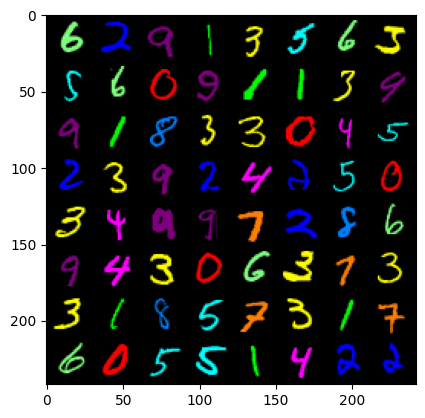

    6     2     9     1     3     5     6     3


In [18]:
# Function to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #the transpose allow the image to be in the good shape for plt.imshow
    plt.show()

# Get some training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join('%5s' % labels[j].item() for j in range(8)))


Create your model here. Consider looking at pytorch documentation. You can also use CNN for instance. Pretrained models are forbidden. Here is an example of a model.

In [19]:
class ColoredNet(nn.Module):
    def __init__(self):
        super(ColoredNet, self).__init__()
        self.fc1 = nn.Linear(3 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.25)
        self.relu = nn.ReLU()
        self.flat = nn.Flatten()

    def forward(self, x):
        x = self.flat(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        return x

net = ColoredNet()

img=train_dataset[0][0]
img=img.unsqueeze(0)  # add a batch dimension
summary(net, input_size = img.size()) # allows you to print the main caracteristics of your model


Layer (type:depth-idx)                   Output Shape              Param #
ColoredNet                               [1, 10]                   --
├─Flatten: 1-1                           [1, 2352]                 --
├─Linear: 1-2                            [1, 128]                  301,184
├─ReLU: 1-3                              [1, 128]                  --
├─Dropout: 1-4                           [1, 128]                  --
├─Linear: 1-5                            [1, 10]                   1,290
├─ReLU: 1-6                              [1, 10]                   --
Total params: 302,474
Trainable params: 302,474
Non-trainable params: 0
Total mult-adds (M): 0.30
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 1.21
Estimated Total Size (MB): 1.22

Define your loss and your optimizer. Consider testing different losses.

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001) #lr is the learning rate, consider changing it. The lower it is, the slower your model learn


The training loop :

In [21]:
num_epochs = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net=net.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in tqdm(train_dataloader):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_dataloader)}")


100%|██████████| 938/938 [00:08<00:00, 108.65it/s]


Epoch 1, Loss: 0.09008931182739104


100%|██████████| 938/938 [00:08<00:00, 111.60it/s]


Epoch 2, Loss: 0.012303532215969281


100%|██████████| 938/938 [00:08<00:00, 108.87it/s]

Epoch 3, Loss: 0.007207978143528664


Then you create your testset. Here, you have to create another class than the one used for the training set because of course you don't have access to the labels.

In [25]:
#change the difficulty by replacing "easy" by "medium" or "hard"
loaded_test_images = load_from_gz('colored_mnist_test_images_easy.gz')

class TestMNISTDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        return torch.tensor(image)

# Create the new dataset
test_dataset = TestMNISTDataset(loaded_test_images)

# Create a DataLoader for the new dataset
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

Then in order to get your model's accuracy you have to create your predictions.npy file and to upload this file on CS sharing (according to the difficulty you've chosen).

In [23]:

predictions=[]

for img in test_dataloader :
    img = img.to(device)
    l=np.array(net(img.float()).tolist())
    predicted=[]
    for i in range(len(l)) :
        predicted.append(np.argmax(l[i]))
    predictions.extend(predicted)



np.save('predictions.npy', predictions)